In [4]:
import pandas as pd 
import matplotlib.pyplot as plt 
import catboost as cbt 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from catboost import CatBoostRanker,Pool

In [5]:
import csv

# Step 1: Read raw data
with open("movies.dat", "r", encoding="utf-8") as infile:
    lines = infile.readlines()

# Step 2: Process and write to CSV
with open("movies.csv", "w", newline='', encoding="utf-8") as outfile:
    writer = csv.writer(outfile)
    writer.writerow(["movieId", "title", "genres"])  # Header

    for line in lines:
        parts = line.strip().split("::")
        if len(parts) == 3:
            movie_id, title, genres = parts
            writer.writerow([movie_id, title, genres])


In [6]:
import csv

# Step 1: Read raw data
with open("ratings.dat", "r", encoding="utf-8") as infile:
    lines = infile.readlines()

# Step 2: Write to CSV
with open("ratings.csv", "w", newline='', encoding="utf-8") as outfile:
    writer = csv.writer(outfile)
    writer.writerow(["userId", "movieId", "rating", "timestamp"])  # CSV header

    for line in lines:
        parts = line.strip().split("::")
        if len(parts) == 4:
            writer.writerow(parts)


In [7]:
rating=pd.read_csv('ratings.csv')
movie=pd.read_csv('movies.csv')

In [8]:
rating.head()

,userId,movieId,rating,timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392
3,1,292,5.0,838983421
4,1,316,5.0,838983392


In [9]:
movie

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
10676,65088,Bedtime Stories (2008),Adventure|Children|Comedy
10677,65091,Manhattan Melodrama (1934),Crime|Drama|Romance
10678,65126,Choke (2008),Comedy|Drama
10679,65130,Revolutionary Road (2008),Drama|Romance


In [10]:
data = pd.merge(rating, movie, on="movieId")

In [11]:
data.head()

,userId,movieId,rating,timestamp,title,genres
0,1,122,5.0,838985046,Boomerang (1992),Comedy|Romance
1,1,185,5.0,838983525,"Net, The (1995)",Action|Crime|Thriller
2,1,231,5.0,838983392,Dumb & Dumber (1994),Comedy
3,1,292,5.0,838983421,Outbreak (1995),Action|Drama|Sci-Fi|Thriller
4,1,316,5.0,838983392,Stargate (1994),Action|Adventure|Sci-Fi


In [12]:
# Clean the data

data['genres']=data['genres'].apply(lambda x:x.split('|')[0])

In [13]:
data['genres']

0              Comedy
1              Action
2              Comedy
3              Action
4              Action
              ...    
10000049       Horror
10000050       Action
10000051    Adventure
10000052       Horror
10000053     Children
Name: genres, Length: 10000054, dtype: object

In [14]:
data['userId']=data['userId'].astype('category')
data['movieId']=data['movieId'].astype('category')
data['genres']=data['genres'].astype('category')

In [15]:
data['userId']

0               1
1               1
2               1
3               1
4               1
            ...  
10000049    71567
10000050    71567
10000051    71567
10000052    71567
10000053    71567
Name: userId, Length: 10000054, dtype: category
Categories (69878, int64): [1, 2, 3, 4, ..., 71564, 71565, 71566, 71567]

In [16]:
print(data['userId'].memory_usage(deep=True))

42672948


In [17]:
feature=['userId','movieId','genres']
x=data[feature]
y=data['rating']

In [18]:
group_id=data['userId'].cat.codes

In [19]:
x_train,x_test,y_train,y_test,g_train,g_test=train_test_split(x,y,group_id,test_size=0.2,random_state=42,stratify=group_id)


In [20]:
print(x_train.shape)
print(y_train.shape)

(8000043, 3)
(8000043,)


In [21]:
group_id=data['userId'].cat.codes

In [22]:
group_id

0               0
1               0
2               0
3               0
4               0
            ...  
10000049    69877
10000050    69877
10000051    69877
10000052    69877
10000053    69877
Length: 10000054, dtype: int32

In [23]:
x_test

,userId,movieId,genres
7918183,56794,1485,Comedy
3838694,27562,223,Comedy
5621659,40166,1466,Crime
5959705,42522,70,Action
2283988,16612,421,Adventure
...,...,...,...
6854510,48962,2013,Action
5502604,39294,912,Drama
7369035,52644,8798,Action
7212979,51544,21,Action


In [24]:
import pandas as pd

train_df = x_train.copy()
train_df['label'] = y_train
train_df['group_id'] = g_train
train_df.sort_values(by='group_id', inplace=True)


In [25]:
x_train_sorted = train_df.drop(['label', 'group_id'], axis=1)
y_train_sorted = train_df['label']
g_train_sorted = train_df['group_id']

In [26]:
train_df = x_train.copy()
train_df['label'] = y_train
train_df['group_id'] = g_train

In [27]:
train_df.sort_values(by='group_id', inplace=True)

In [28]:
x_train_sorted = train_df.drop(['label', 'group_id'], axis=1)
y_train_sorted = train_df['label']
g_train_sorted = train_df['group_id']

In [29]:
# train_pool=Pool(data=x_train,label=y_train,group_id=g_train,cat_features=[0,1,2])

# test_pool=Pool(data=x_test,label=y_test,group_id=g_test,cat_features=[0,1,2])

train_pool = Pool(data=x_train_sorted,
                  label=y_train_sorted,
                  group_id=g_train_sorted,
                  cat_features=[0, 1, 2])

import pandas as pd
from catboost import Pool

# Combine test features, labels, and group IDs
test_df = x_test.copy()
test_df['label'] = y_test
test_df['group_id'] = g_test

# Sort by group_id to make CatBoost happy
test_df.sort_values(by='group_id', inplace=True)

# Split back into X, y, and group_id
x_test_sorted = test_df.drop(['label', 'group_id'], axis=1)
y_test_sorted = test_df['label']
g_test_sorted = test_df['group_id']

# Now create the test pool
test_pool = Pool(
    data=x_test_sorted,
    label=y_test_sorted,
    group_id=g_test_sorted,
    cat_features=[0, 1, 2]  )

In [30]:
model = CatBoostRanker(
    iterations=10,
    learning_rate=0.1,
    depth=6,
    loss_function='YetiRank',
    verbose=1,task_type='CPU',random_state=42,)

In [31]:
model.fit(train_pool)

Groupwise loss function. OneHotMaxSize set to 10
0:	total: 48.5s	remaining: 7m 16s
1:	total: 1m 32s	remaining: 6m 8s
2:	total: 2m 19s	remaining: 5m 25s
3:	total: 3m 12s	remaining: 4m 49s
4:	total: 3m 56s	remaining: 3m 56s
5:	total: 4m 41s	remaining: 3m 7s
6:	total: 5m 37s	remaining: 2m 24s
7:	total: 6m 21s	remaining: 1m 35s
8:	total: 7m 3s	remaining: 47s
9:	total: 7m 47s	remaining: 0us


In [46]:
from sklearn.metrics import r2_score
y_pred=model.predict(test_pool)
x_test['predicted_score'] = y_pred
print(r2_score(y_test,y_pred))

-11.188367964946389


In [42]:
result = pd.concat([x_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)

# Show top recommendations per user
top_per_user = result.groupby('userId').apply(lambda df: df.sort_values(by='predicted_score', ascending=False).head(3))


C:\Users\praja\AppData\Local\Temp\ipykernel_1488\608742923.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_per_user = result.groupby('userId').apply(lambda df: df.sort_values(by='predicted_score', ascending=False).head(3))
C:\Users\praja\AppData\Local\Temp\ipykernel_1488\608742923.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_per_user = result.groupby('userId').apply(lambda df: df.sort_values(by='predicted_score', ascending=False).head(3))


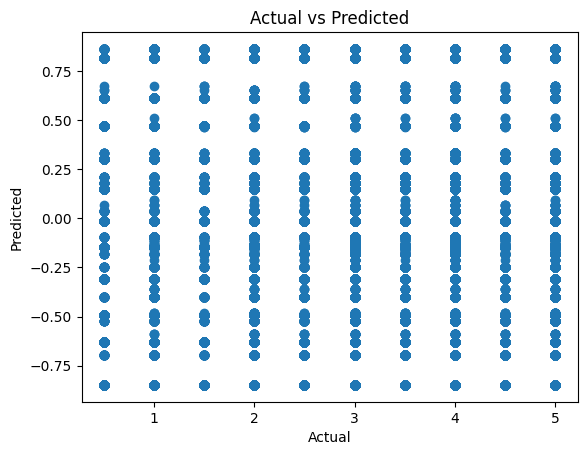

In [48]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()

In [43]:
print(top_per_user)

               userId movieId    genres  predicted_score  rating
userId                                                          
1      1686365      1     539    Comedy         0.614286     5.0
       567672       1     356    Comedy         0.151040     5.0
       257088       1     370    Action        -0.013606     5.0
2      862217       2    1391    Action         0.304481     3.0
       136020       2     539    Comedy        -0.013606     3.0
...               ...     ...       ...              ...     ...
71566  1166900  71566      36     Crime         0.815029     5.0
       1843059  71566      34  Children         0.614286     4.0
71567  789213   71567    1690    Action         0.472502     3.0
       1595571  71567     256    Comedy         0.472502     3.0
       1368124  71567     110    Action         0.151040     5.0

[209634 rows x 5 columns]
